# Import Libraries

In [1]:
#!pip install --upgrade scipy
#!pip install plotly
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f
from scipy.special import betainc
from scipy.stats import norm, f
from scipy.ndimage import rotate
import re
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from pandas.plotting import parallel_coordinates

# Define Parameters

In [91]:
# Define parameters
alphas = [0.05]#, 0.01, 0.005, 0.001]
f2s = [0.2]#, 0.2, 0.3]
df = 2 #association tests - 2 way ANOVA
Ns = [100]#[50, 100, 150, 200]

# Define Functions

In [3]:
# Function to load NIfTI images
def load_nii(filename):
    return nib.load(filename)

In [15]:
# 3D Plot
def plot_3d_scatter(df):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df["Power"], df["PVal"], df["SecGenPVal"], c='blue', marker='o')
    
    ax.set_xlabel("Power")
    ax.set_ylabel("PVal")
    ax.set_zlabel("SecGenPVal")
    ax.set_title("3D Scatter Plot")

    #ax.view_init(elev=20, azim=30)
    plt.show()


# Parallel Plot
def plot_parallel_coordinates(df):
    df_norm = (df - df.min()) / (df.max() - df.min())  # Normalize values
    df_norm["Category"] = "Data"  # Needed for the color grouping
    parallel_coordinates(df_norm, class_column="Category", colormap="coolwarm")
    plt.title("Parallel Coordinates Plot")
    plt.show()

In [5]:
# Function to compute z-score from alpha
def z_score_from_alpha(alpha, tail='two-sided'):
    """
    Calculates the z-score from a given alpha value.

    Parameters:
    alpha (float): Significance level (e.g., 0.05).
    tail (str): Type of test tail ('two-sided', 'left', or 'right').
                  Defaults to 'two-sided'.

    Returns:
    float: Z-score corresponding to the alpha value.
    """
    if tail == 'two-sided':
        z = norm.ppf(1 - alpha/2)
    elif tail == 'left':
        z = norm.ppf(alpha)
    elif tail == 'right':
         z = norm.ppf(1 - alpha)
    else:
        raise ValueError("tail must be 'two-sided', 'left', or 'right'")
    return z

In [6]:
# Function for power and statistic p-value calculations
def power_calcs2(df1, df2, f2, alpha, Contrast_img):

    Fcrit = f.ppf(1 - alpha, df1, df2) # returns the inverse cumulative distribution function of the F distribution with degrees of freedom df1 and df2, evaluated at the probability value of 1 - alpha

    SPM_ZtoP = 2 * (1 - norm.cdf(Contrast_img)) #where SPM_Zobs was hardcoded 1.75 - do we need the absolute value of the zscore?

    lambda_ = (df1 + df2 + 1) * f2
    kappa = (df1 + lambda_) / df1
    df2_lambda = ((df1 + lambda_) ** 2) / (df1 + 2 * lambda_)

    F_prime = Fcrit / kappa
    x = (df2_lambda * F_prime) / (df2 + df2_lambda * F_prime)
    beta = betainc(df2_lambda / 2, df2 / 2, x)

    power = 1 - beta

    return power, SPM_ZtoP

In [81]:
# Function for second generation p-value calculations
def calculate_second_gen_p_value(observed_effect, null_hypothesis, effect_interval, f2, n, alpha, df, debug = True):
    """
    Calculate second-generation p-value for neuroimaging data
    
    Parameters:
        observed_effect (float): Estimated effect size from neuroimaging analysis - Contrast_img (z scores)
        null_hypothesis (float): Point null hypothesis value #### this should be the mean of the population (which for fmri is 0)
        effect_interval (float): Interval of practically equivalent effects - Contrast_Scaled (cohen's f^2 based on f2 power value)
    
    Returns:
        tuple: (delta_p, interpretation)
    """
    if debug:
        print(f'N: {n}')
        print(f'alpha: {alpha}')
        print(f'df: {df}')

        # Transform cohen's f^2 to cohen's d (effect_interval) using formula d = 2f
        print(f'Cohens f2: {f2}')
        d = 2*f2
        print(f'Cohens d: {d}\n')

        print(f'Z-score: {observed_effect}')
        # Transform z-scores to t-scores
        #t_val = d*np.sqrt(n)
        #t_val = observed_effect * np.sqrt(n) / (1 - (d**2/2))
        t_val = observed_effect / (d*np.sqrt(n))
        print(f'T-score: {t_val}')
        
        ##### CI Interval for each voxel #####

        # Calculate Standard Error
        if df == 2:
            std = z_score_from_alpha(alpha, tail='two-sided') # assuming 2-tailed test (ANOVA) (1.96 at alpha 0.05) - need to take into account both tails
        elif df == 1:
            std = z_score_from_alpha(alpha, tail='right') # assuming 1-tailed test (1.64 at alpha 0.05) - need to take into account only right tail
        else:
            print('error - no df specified')
        print(f'SD: {std}')
        
        # Standard error calculated from the sample size and standard deviation (from the alpha value)
        std_error = std / np.sqrt(n-df) # n-1 because ANOVA association tests
        print(f'SE: {std_error}')


        # Lower and upper bounds of confidence interval
        ci_lower = t_val - std_error # observed_effect is the z_score and std error is the variance/CI around the z score
        ci_upper = t_val + std_error
        print(f'Confidence Interval: [{ci_lower},{ci_upper}]\n')
        
        ##### H0 Interval for overall study #####
        print(f'Null Hypothesis: {null_hypothesis}')
        # Transform width of null interval based on effect interval
        #effect_interval = effect_interval*d
        print(f'Effect Interval Test Value: {effect_interval}')
    

        # Lower and upper bounds of effect interval
        interval_lower = null_hypothesis - effect_interval # null hypothesis 0 +/- cohen's d scaled by input
        interval_upper = null_hypothesis + effect_interval
        print(f'Null Interval: [{interval_lower},{interval_upper}]\n')
        
        # Calculate second-generation p-value
        if ci_upper <= interval_upper and ci_lower >= interval_lower: #CI entirely contained in the indifference zone (interval)
            # Conclusive evidence against null
            delta_p = 1.0
            interpretation = 'The data supports the null hypothesis - not scientifically or clinically meaningful'
        elif ci_upper < interval_lower or ci_lower > interval_upper: #absolutely no overlap of CI with the indifference zone 
            # Confidence interval completely covers equivalence interval
            delta_p = 0.0
            interpretation = 'The data supports an alternative hypothesis that is scientifically OR clinically meaningful'
        elif (ci_upper - ci_lower) > (2*(interval_upper-interval_lower)): 
            # Confidence interval more than twice the length of the null interval (p.4 and top p.6)
            delta_p = 0.5
            interpretation = 'Data is strictly inconclusive'
        else: 
            # Confidence interval less than twice the length of the null interval (p.4)
            # Partial overlap (either above or below null interval) - ### is there a situation in which it could be both?
            overlap_lower = max(ci_lower, interval_lower)
            overlap_upper = min(ci_upper, interval_upper)
            
            # Calculate proportion of overlap
            delta_p = (overlap_upper - overlap_lower) / (ci_upper - ci_lower)
            interpretation = 'Partial evidence, some consistency with null' #overlap fraction

        print(f'Second Gen p-value: {delta_p}') 
        print(f'Interpretation: {interpretation}')  
    
    else:

        # Transform cohen's f^2 to cohen's d (effect_interval) using formula d = 2f
        d = 2*f2

        # Transform z-scores to t-scores
        #t_val = d*np.sqrt(n)
        #t_val = observed_effect * np.sqrt(n) / (1 - (d**2/2))
        t_val = observed_effect / (d*np.sqrt(n))
        
        ##### CI Interval for each voxel #####

        # Calculate Standard Error
        if df == 2:
            std = z_score_from_alpha(alpha, tail='two-sided') # assuming 2-tailed test (ANOVA) (1.96 at alpha 0.05) - need to take into account both tails
        elif df == 1:
            std = z_score_from_alpha(alpha, tail='right') # assuming 1-tailed test (1.64 at alpha 0.05) - need to take into account only right tail
        else:
            print('error - no df specified')
        
        # Standard error calculated from the sample size and standard deviation (from the alpha value)
        std_error = std / np.sqrt(n-df) # n-1 because ANOVA association tests


        # Lower and upper bounds of confidence interval
        ci_lower = t_val - std_error # observed_effect is the z_score and std error is the variance/CI around the z score
        ci_upper = t_val + std_error
        
        ##### H0 Interval for overall study #####
    
        # Lower and upper bounds of effect interval
        interval_lower = null_hypothesis - effect_interval # null hypothesis 0 +/- cohen's d scaled by input
        interval_upper = null_hypothesis + effect_interval
        
        # Calculate second-generation p-value
        if ci_upper <= interval_upper and ci_lower >= interval_lower: #CI entirely contained in the indifference zone (interval)
            # Conclusive evidence against null
            delta_p = 1.0
            interpretation = 'The data supports the null hypothesis - not scientifically or clinically meaningful'
        elif ci_upper < interval_lower or ci_lower > interval_upper: #absolutely no overlap of CI with the indifference zone 
            # Confidence interval completely covers equivalence interval
            delta_p = 0.0
            interpretation = 'The data supports an alternative hypothesis that is scientifically OR clinically meaningful'
        elif (ci_upper - ci_lower) > (2*(interval_upper-interval_lower)): 
            # Confidence interval more than twice the length of the null interval (p.4 and top p.6)
            delta_p = 0.5
            interpretation = 'Data is strictly inconclusive'
        else: 
            # Confidence interval less than twice the length of the null interval (p.4)
            # Partial overlap (either above or below null interval) - ### is there a situation in which it could be both?
            overlap_lower = max(ci_lower, interval_lower)
            overlap_upper = min(ci_upper, interval_upper)
            
            # Calculate proportion of overlap
            delta_p = (overlap_upper - overlap_lower) / (ci_upper - ci_lower)
            interpretation = 'Partial evidence, some consistency with null' #overlap fraction
 
    return delta_p


In [85]:
calculate_second_gen_p_value(
    observed_effect = 3.5, 
    null_hypothesis = 0, 
    effect_interval = 1, 
    f2 = 0.2, 
    n = 100, 
    alpha = 0.05,
    df = 2,
    debug=True
    )

N: 100
alpha: 0.05
df: 2
Cohens f2: 0.2
Cohens d: 0.4

Z-score: 3.5
T-score: 0.875
SD: 1.959963984540054
SE: 0.19798626062138255
Confidence Interval: [0.6770137393786174,1.0729862606213825]

Null Hypothesis: 0
Effect Interval Test Value: 1
Null Interval: [-1,1]

Second Gen p-value: 0.8156784708385468
Interpretation: Partial evidence, some consistency with null


0.8156784708385468

# Power, P-Val, and 2nd Gen P-Val

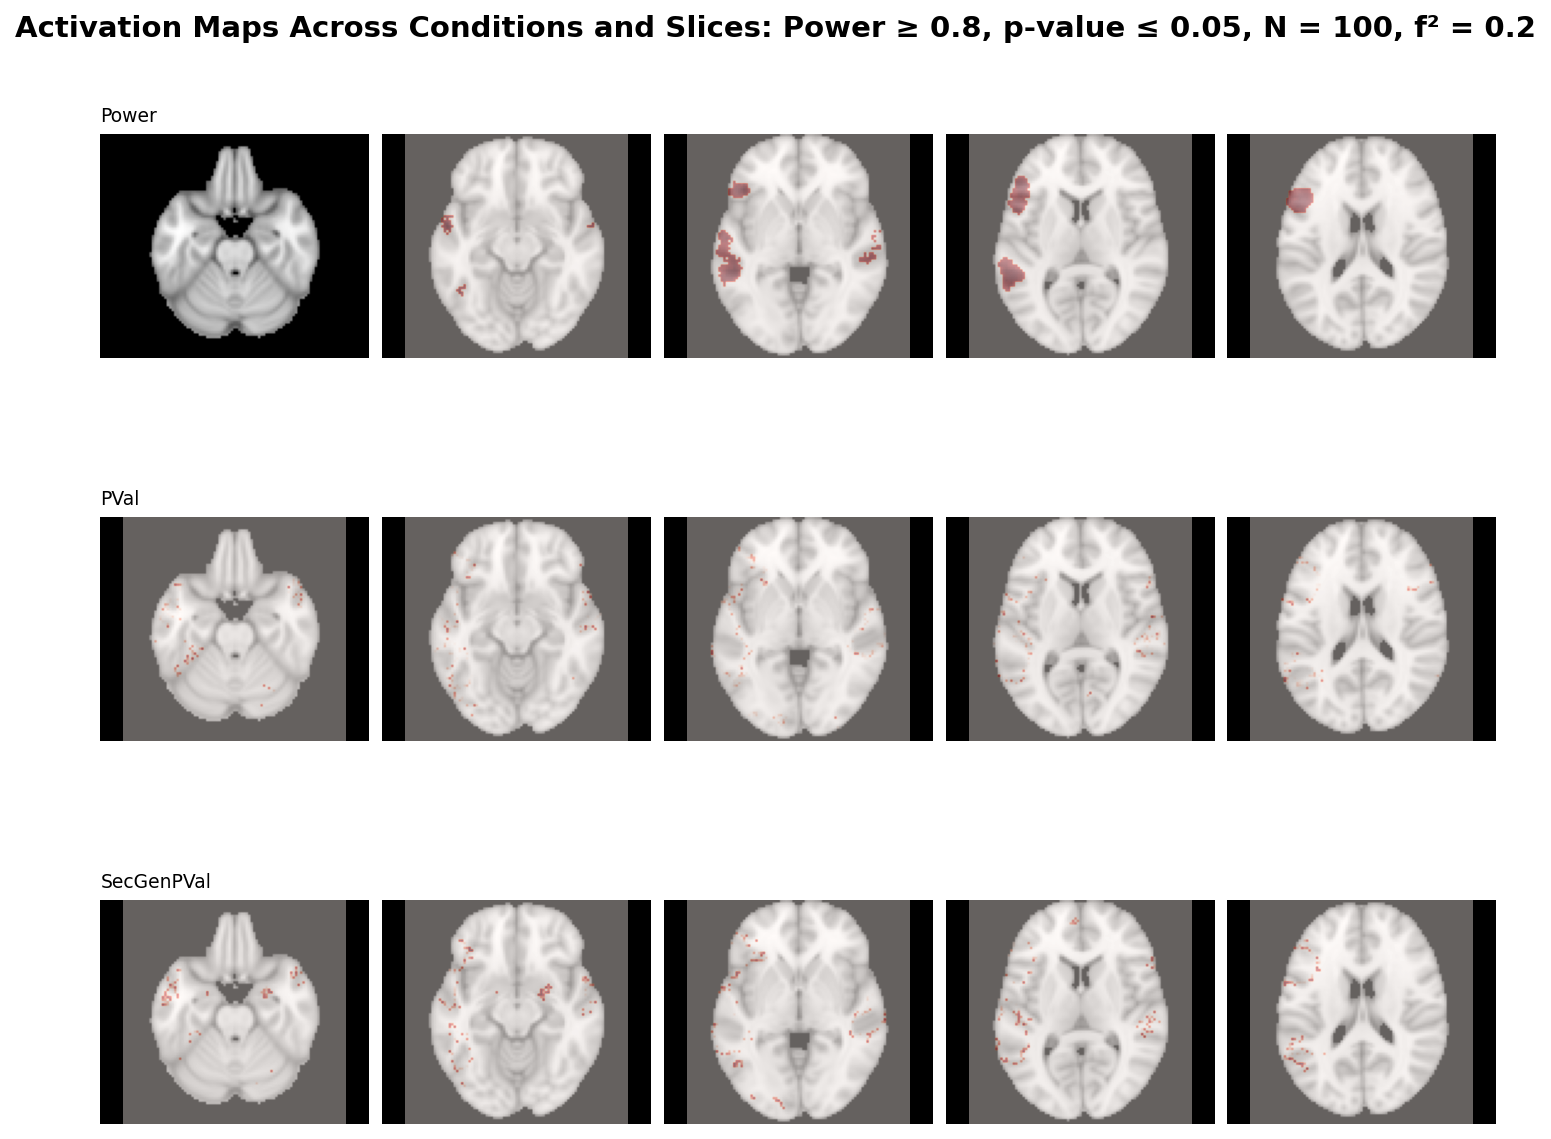

               Power           PVal     SecGenPVal
count  902629.000000  902629.000000  902629.000000
mean        0.002830       0.000001       0.000947
std         0.049890       0.000020       0.018129
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%         0.000000       0.000000       0.000000
75%         0.000000       0.000000       0.000000
max         0.991741       0.000673       0.499211


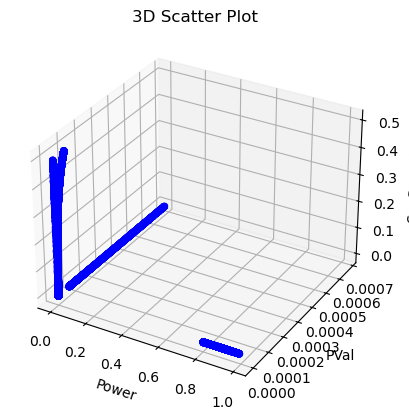

In [93]:
# Define parameters
alphas = [0.05]
f2s = [0.2]
df = 2 #association tests - 2 way ANOVA
Ns = [100]
effect_interval = 1


# Load fMRI images
MNIAtlas = load_nii('anatomical.nii.gz')
#Contrast = load_nii('language_uniformity-test_z_FDR_0.01.nii.gz')
Contrast = load_nii('language_association_test_z_FDR_0.01.nii.gz')

# Extract image data
Contrast_img = Contrast.get_fdata()

# Compute max contrast
MaxContrast = np.max(Contrast_img)

for f2 in f2s:
    # Scale contrast images
    Contrast_Scaled = (f2 / MaxContrast) * Contrast_img

    # Get image dimensions correctly
    XDIM, YDIM, ZDIM = Contrast_img.shape
    PowerImage = np.zeros((XDIM, YDIM, ZDIM))
    PvalImage = np.zeros((XDIM, YDIM, ZDIM))
    SecGenPvalImage = np.zeros((XDIM, YDIM, ZDIM))

    for n in Ns:
        for alpha in alphas:
            for i in range(XDIM):
                for j in range(YDIM):
                    for k in range(ZDIM):
                        if Contrast_Scaled[i, j, k] != 0: ##### Shouldn't this  be != 0 - not >0? There are negative z scores
                            stat_power, _ = power_calcs2(df, n, Contrast_Scaled[i, j, k], alpha, Contrast_img[i, j, k]) # only calculate power on non-0 values
                        if Contrast_img[i, j, k] != 0:
                            _ , stat_pval = power_calcs2(df, n, Contrast_img[i, j, k], alpha, Contrast_img[i, j, k])
                            secgenpval = calculate_second_gen_p_value(Contrast_img[i, j, k], 0, effect_interval, f2, n, alpha, df, debug=False)
                            
                            # Power analysis
                            PowerThreshold = 1 - f2
                            if stat_power >= PowerThreshold:
                                PowerImage[i, j, k] = stat_power #adjusts 3d matrix on values to only include power values that meet threshold (overwrites default zeros)
                            # Pval analysis
                            if stat_pval <= alpha:
                                PvalImage[i, j, k] = stat_pval 
                            # Second Gen Pval analysis
                            if secgenpval <= 0.5:
                                SecGenPvalImage[i, j, k] = secgenpval 

            # Create empty dataframe
            table = pd.DataFrame()

            # Format filename correctly
            pvalue = str(alpha).replace('0.', '')
            f2value = str(f2).replace('0.', '0')

            # Save power image as a NIfTI file
            power_filename = f'images/PowerContrast_N{n}_p{pvalue}_Power{int(PowerThreshold * 100)}_f2{f2value}.nii.gz'
            PowerImage_nii = nib.Nifti1Image(PowerImage, Contrast.affine, Contrast.header)
            nib.save(PowerImage_nii, power_filename)

            # Save pval image as a NIfTI file
            pval_filename = f'images/PValContrast_N{n}_p{pvalue}_Power{int(PowerThreshold * 100)}_f2{f2value}.nii.gz'
            PvalImage_nii = nib.Nifti1Image(PvalImage, Contrast.affine, Contrast.header)
            nib.save(PvalImage_nii, pval_filename)

            # Save second gen pval image as a NIfTI file
            secgenpval_filename = f'images/SecGenPValContrast_N{n}_p{pvalue}_Power{int(PowerThreshold * 100)}_f2{f2value}.nii.gz'
            SecGenPvalImage_nii = nib.Nifti1Image(SecGenPvalImage, Contrast.affine, Contrast.header)
            nib.save(SecGenPvalImage_nii, secgenpval_filename)


            #### CONTRAST PLOTS ####
            # Define the activation files
            activation_files = [power_filename, pval_filename, secgenpval_filename]

            # Load the anatomical image
            img = nib.load('anatomical.nii.gz')
            data = img.get_fdata()

            # Define slices to extract
            slices_indices = [24, 30, 35, 40, 45]

            # Set up the figure
            fig, axes = plt.subplots(len(activation_files), len(slices_indices), figsize=(12, 9), dpi=150)

            # Loop through activation files
            for row, activation_file in enumerate(activation_files):
                # Load activation data
                activation = nib.load(activation_file)
                activation_data = activation.get_fdata()

                # Extract metadata from filename
                match = re.search(r'images\/(\w+)Contrast_N(\d+)_p(\d+)_Power(\d+)_f2(\d+).nii.gz', activation_file)
                if match:
                    stat_choice = match.group(1)
                    f_value = float(match.group(5)) / 10
                    n_value = match.group(2)
                    p_value = float(match.group(3)) / 100
                    power_value = float(match.group(4)) / 100
                    title_text = f"{stat_choice}"
                else:
                    title_text = "Activation Map"

                # Append data to empty dataframe
                lst = list(activation_data.flatten())
                table[stat_choice] = lst

                # Loop through slices
                for col, slice_idx in enumerate(slices_indices):
                    slice_img = data[:, :, slice_idx]
                    activation_img = activation_data[:, :, slice_idx]

                    # Rotate images
                    rotated_slice = np.flip(rotate(slice_img, 90, reshape=False, mode='constant', cval=0), axis=1)
                    rotated_activation = np.flip(rotate(activation_img, 90, reshape=False, mode='constant', cval=0), axis=1)

                    ax = axes[row, col] if len(activation_files) > 1 else axes[col]
                    ax.imshow(rotated_slice, cmap='gray')
                    ax.imshow(np.ma.masked_where(rotated_activation == 0, rotated_activation), cmap='Reds', alpha=0.4)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    ax.set_frame_on(False)

                    # Add title to first column in each row
                    if col == 0:
                        ax.set_title(title_text, fontsize=9, loc='left')

            # Optional global figure title
            fig.suptitle(f"Activation Maps Across Conditions and Slices: Power ≥ {power_value}, p-value ≤ {p_value}, N = {n_value}, f² = {f_value}", fontsize=14, fontweight='bold', y=0.95)
            plt.subplots_adjust(wspace=0.05, hspace=0.4)
            plt.show()


            ### VISUALIZE Table (only contains thresholded values - everything else 0s###
            #print(table.head())
            print(table.describe())
            #table['SecGenPVal'] = np.random.uniform(0, 0.1, size=len(table))
            
            # 3D Plot
            plot_3d_scatter(table)

            # Parallel Plot
            #plot_parallel_coordinates(table)